# Introduction

## Ema's Original Formulation

Schematically, Ema's idea is to model the probability of a new pixel being settled, conditional on the initial settlement pattern, as 

$$p_i = \sum_j a_{ij} p_j(i; \theta)\;,$$

where $a_{ij}$ is the probability that pixel $i$ is of "type" $j$ (e.g. $j \in \{\text{urban, rural}\})$, and $p_j(i; \theta)$ is the probability of type-$j$ settlement given the initial settlement pattern and some parameters $\theta$. 

Ema's original form of this model is to take $a_{ij} = \alpha_j$ to be a parameter that is constant for all pixels $i$, and and to take $p_j(i; \theta$ to have the form 

$$ p_j(i; \theta) = \frac{\sum_{k \in \mathcal{W}_j} d_{ik}^{-\gamma}}{\sum_{k \in \mathcal{W}} d_{ik}^{-\gamma}}\;.$$ 

In this expression, $\mathcal{W}$ is the entire map and $\mathcal{W}_j$ is the set of all settled pixels of type $j$. $\mathcal{W}_j$ is determined according to a size-based thresholding, so, for example, clusters of certain size are considered to be urban. 

## A Small Modification

The modification I suggest to Ema's original formulation is pretty simple: we add a parameter and pass the first expression through a logistic sigmoid function: 

$$p_i = \sigma\left(\sum_j a_{ij} p_j(i; \theta) + \beta\right)\;,$$

where $\sigma(x) = (1 + e^{-x})^{-1}$. This model turns out to have considerably richer behavior (i.e. we "get our money's worth" for the extra parameter $\beta$), and has parameters that are easier to estimate. It mainly does this by avoiding mathematical difficulties in Ema's original formulation; for example, unlike the very first expression, the modified one is always a correctly normalized probability. 

## The Method

I had previously been convinced that the correct way to model the settlement phenomena would be using latent-variable methods, in which case we could apply nice alternating-projection algorithms to the problem. However, the most performant approach so far has been the "dumb" approach associated with performing simple maximum-likelihood estimation using a Python solver. 

Let's see a quick demonstration of the method. What we're going to do is:

1. Construct an initial map. 
2. Simulate one time-step of the evolution based on some known parameters. 
3. Treat this simulation as "data" and attempt to learn what the parameters were. 

As we'll see, this framework is fairly successful at this task. This is important: if it weren't, the parameters wouldn't be "identifiable," and the problem of parameter estimation would be impossible under this model. 

Let's see this in action! 

# Demo

The code for the `urban_growth.simulator` and `urban_growth.estimator` classes is located in the same GitHub repo. 

In [1]:
from urban_growth.simulator import *
from urban_growth.estimator import *
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

## Set Parameters

We have parameters for: the initial map configuration, the model type, the size threshold determining the rural/urban distinction, and the $\alpha$, $\beta$, and $\gamma$ above. We also have a geographic mask that makes some areas harder to settle than others. In this example, the geographic mask discourages settlement on the west and encourages settlement in the east. 

In [2]:
# Initial Configuration. 
L = 300
rho = .47
blur = 3

# model type
model = 'logistic'

# rural-to-urban threshold
T_vec = [200]

# dynamical parameters
pars = {'alpha' : np.array([90, 80]),
        'gamma' : np.array([1.0, 3.0]),
        'beta' : np.array([-10])
       }

trunc = 50

# geographic mask
geo = np.ones((L, L))

for i in np.arange(0, L):
    geo[:,i] = 1.0*i / L 

Now we'll create a random matrix to be our initial condition, construct a `simulator` object based on that matrix, and then run the dynamics for one time-step. In the plot below, white spots are old settlements, pink spots are new settlements, and blue spots are unsettled. 

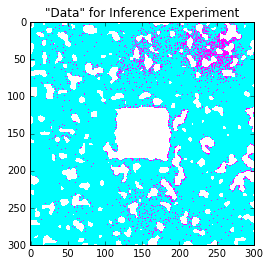

In [3]:
M0 = random_mat(L, rho, blur = blur)
m = simulator(M0 = M0, geo = geo, model = model, trunc = trunc)

M1 = m.dynamics(T_vec = T_vec,
                n_iters = 1, 
                verbose = False,  
                **pars)

X = M1 - m.M0
X[m.M0 == 1] = np.nan
im = plt.imshow(X, interpolation = 'nearest', cmap = 'cool')
plt.title('"Data" for Inference Experiment')

## Estimation

Now we'll initialize an estimator and prepare it for the estimation task: 

In [4]:
e = estimator(M0 = M0, geo = geo, model = model)
e.update_morphology()

e.dist_array = m.dist_array # bit of a hack

e.partition_clusters(T_vec)
e.partition_dist_array()
    
e.logistic_log_likelihood(X, 
                          normalized = True, 
                          use_grad = False, 
                          **pars)

urban_growth/estimator.py:22: RuntimeWarning: divide by zero encountered in log
  ll = np.nansum(X*np.log(d)+(1-X)*np.log(1-d))
urban_growth/estimator.py:22: RuntimeWarning: invalid value encountered in multiply
  ll = np.nansum(X*np.log(d)+(1-X)*np.log(1-d))


-0.16450218145792708

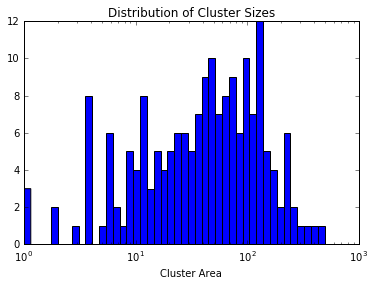

In [5]:
plt.hist(e.areas.values(), bins=np.logspace(0.0, 3.0, 50))
plt.gca().semilogx()
plt.gca().set(xlabel = 'Cluster Area')
t = plt.title('Distribution of Cluster Sizes')

In [6]:
pars_hat = {'alpha' : np.array([50, 80]),
          'gamma' : np.array([3.5, 2.8]), 
          'beta'  : np.array([-2])
         }

def f(T, pars_hat):
    e.partition_clusters(np.array([T]))
    e.partition_dist_array()

    pars_hat, ll_hat, h_inv = e.logistic_ML(X, 
                                            pars_hat, 
                                            use_grad = True, 
                                            opts = {'disp' : False},
                                            tol = .00001)
    print T, ll_hat
    return T, ll_hat

test = np.array([f(T, pars_hat) for T in sorted(set(m.areas.values()), reverse = True) if T > 100])

5010 -0.205034372968
434 -0.196492689563
382 -0.189098322695
358 -0.192877636264
298 -0.187967304227
250

urban_growth/estimator.py:24: RuntimeWarning: invalid value encountered in divide
  coef = X / d - (1 - X) / (1 - d)
urban_growth/components.py:60: RuntimeWarning: overflow encountered in multiply
  d_gamma = np.expand_dims(np.expand_dims(alpha, 1), 2) * (df * norm - dnorm * f) / norm ** 2


 -0.183587669975
247 -0.181163800582
237 -0.178759823794
235 -0.17634713784
230 -0.174466248881
229 -0.17114397746
228 -0.169237768982
218 -0.167086802656
210 -0.165693630481
208 -0.164476832775
184 -0.167255526627
181 -0.167688523949
177 -0.168491806798
171 -0.170052640425
157 -0.174213215732
156 -0.175524212111
151 -0.176463315797
139 -0.181097201003
130 -0.18057109087
129 -0.18068926127
128 -0.181316510571
127 -0.187289657667
126 -0.191511951317
124 -0.193188280305
122 -0.194623441922
121 -0.193525889847
119 -0.196153992167
116 -0.198614646262
113 -0.196721291425
109 -0.196999216685
108 -0.196457472471
107 -0.202476493693
104 -0.201977146997
103 -0.207040998168


urban_growth/components.py:60: RuntimeWarning: invalid value encountered in subtract
  d_gamma = np.expand_dims(np.expand_dims(alpha, 1), 2) * (df * norm - dnorm * f) / norm ** 2
urban_growth/components.py:60: RuntimeWarning: overflow encountered in square
  d_gamma = np.expand_dims(np.expand_dims(alpha, 1), 2) * (df * norm - dnorm * f) / norm ** 2


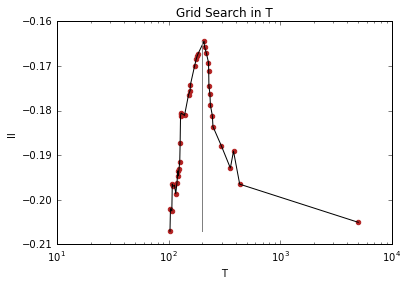

In [7]:
plt.plot(test[:,0], test[:,1], color = 'black')
plt.scatter(test[:,0], test[:,1], color = 'firebrick')
plt.plot([T_vec[0], T_vec[0]], 
         [test[:,1].min(), test[:,1].max()], 
         color = 'grey')

plt.gca().set(xlabel = 'T', ylabel = 'll')
plt.semilogx()
plt.title('Grid Search in T')